In [1]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../../../..')) 

from recidiviz.calculator.modeling.population_projection.super_simulation.super_simulation_factory import SuperSimulationFactory
from recidiviz.calculator.modeling.population_projection.transition_table import TransitionTable
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
from recidiviz.calculator.modeling.population_projection.shell_compartment import ShellCompartment
import pandas as pd
from functools import partial
import yaml

In [2]:
%run ../../../../../../recidiviz-research/utils/research_utils.py

In [3]:
adjust_plot_scale(0.4)

In [65]:
test_sim = SuperSimulationFactory.build_super_simulation('../state/OR/medical_parole_SB_835/or_medical_parole_SB_835_model_inputs.yaml')

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 111/111 [00:00<00:00, 570.02rows/s]
/Users/justine/.local/share/virtualenvs/pulse-data-xK3VhzVV/lib/python3.8/site-packages/google/cloud/bigquery/table.py:1967: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  df[column] = pandas.Series(df[column], dtype=dtypes[column])


outflows_data returned 111 results


Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 31.95rows/s]


transitions_data returned 6 results


Downloading: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 210.58rows/s]


total_population_data returned 39 results


In [66]:
%%bigquery transitions_df
WITH latest_runs AS
(
SELECT simulation_tag, MAX(date_created) as latest_run
FROM `recidiviz-staging.spark_public_input_data.transitions_data_raw`
GROUP BY simulation_tag
)
SELECT data.*
FROM `recidiviz-staging.spark_public_input_data.transitions_data_raw` data
LEFT JOIN latest_runs ON data.simulation_tag = latest_runs.simulation_tag
WHERE data.simulation_tag = 'OR_835'
    AND date_created = latest_runs.latest_run
ORDER BY compartment, compartment_duration

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.09rows/s]


In [67]:
transitions_df

,simulation_tag,compartment_duration,compartment,outflow_to,total_population,crime,crime_type,age,race,date_created
0,OR_835,14.0,med_parole,release,1.00,None,None,x,None,2021-10-20 12:56:39.349718+00:00
1,OR_835,55.0,prison,med_parole,0.00,None,None,x,None,2021-10-20 12:56:39.349718+00:00
2,OR_835,69.0,prison,release,1.00,None,None,x,None,2021-10-20 12:56:39.349718+00:00
3,OR_835,36.0,release,prison,0.18,None,None,x,None,2021-10-20 12:56:39.349718+00:00
4,OR_835,36.0,release,release_full,0.82,None,None,x,None,2021-10-20 12:56:39.349718+00:00
5,OR_835,1.0,release_full,release_full,1.00,None,None,x,None,2021-10-20 12:56:39.349718+00:00


In [84]:
# eligible_population_percent = 118 / 12097 / 12
eligible_population_percent = 0.08

policy_transitions = transitions_df[
    ["compartment_duration", "compartment", "outflow_to", "total_population", "age"]]
transitions_to_med_parole = policy_transitions[policy_transitions["compartment"] == "prison"].copy()
transitions_to_med_parole.loc[1, "total_population"] = eligible_population_percent
transitions_to_med_parole.loc[2, "total_population"] = 1 - eligible_population_percent
transitions_to_med_parole.sort_values(by=["compartment", "compartment_duration"])

,compartment_duration,compartment,outflow_to,total_population,age
1,55.0,prison,med_parole,0.08,x
2,69.0,prison,release,0.92,x


In [85]:
transitions_from_med_parole = policy_transitions[policy_transitions["compartment"] == "med_parole"].copy()
transitions_from_med_parole.sort_values(by=["compartment", "compartment_duration"])

,compartment_duration,compartment,outflow_to,total_population,age
0,14.0,med_parole,release,1.0,x


/Users/justine/.local/share/virtualenvs/pulse-data-xK3VhzVV/lib/python3.8/site-packages/pandas/core/indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value


initialization time:  5.749078035354614


/Users/justine/.local/share/virtualenvs/pulse-data-xK3VhzVV/lib/python3.8/site-packages/pandas/core/indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value


initialization time:  4.9868409633636475


/Users/justine/.local/share/virtualenvs/pulse-data-xK3VhzVV/lib/python3.8/site-packages/pandas/core/indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value
/Users/justine/.local/share/virtualenvs/pulse-data-xK3VhzVV/lib/python3.8/site-packages/pandas/core/indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value
/Users/justine/.local/share/virtualenvs/pulse-data-xK3VhzVV/lib/python3.8/site-packages/pandas/core/indexing.py:1667: PerformanceWarning: DataFrame is highly fr

simulation_time:  6.739167928695679


/Users/justine/.local/share/virtualenvs/pulse-data-xK3VhzVV/lib/python3.8/site-packages/pandas/core/indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value
/Users/justine/.local/share/virtualenvs/pulse-data-xK3VhzVV/lib/python3.8/site-packages/pandas/core/indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value
/Users/justine/.local/share/virtualenvs/pulse-data-xK3VhzVV/lib/python3.8/site-packages/pandas/core/indexing.py:1667: PerformanceWarning: DataFrame is highly fr

simulation_time:  6.323080062866211
16659.795669684394


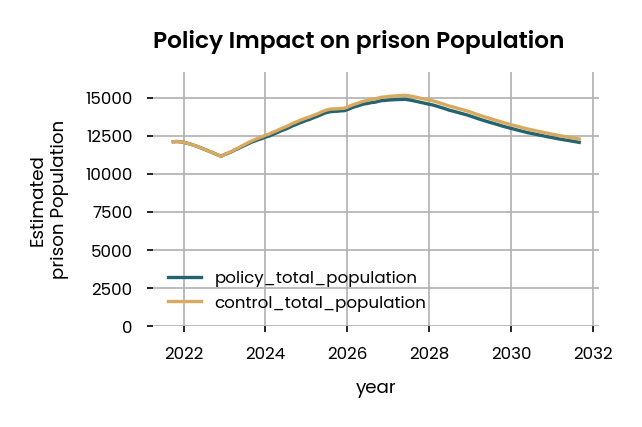

In [86]:
# Policy Simulation
retroactive_flag = True
apply_medical_parole = partial(
    TransitionTable.use_alternate_transitions_data, 
    alternate_historical_transitions=transitions_to_med_parole, 
    retroactive=retroactive_flag
)

policy_list_non_retroactive = [
    SparkPolicy(policy_fn=apply_medical_parole,
                spark_compartment='prison',
                sub_population={'age': 'x'},
                # apply the policy in Jan 2023
                policy_ts=15,
                apply_retroactive=retroactive_flag),
]
    
test_results = test_sim.simulate_policy(policy_list_non_retroactive, 'prison')

In [90]:
simulation_tag = 'OR_835'
results_dict = test_sim.upload_policy_simulation_results_to_bq(simulation_tag)

1it [00:04,  4.86s/it]
1it [00:07,  7.41s/it]
1it [00:04,  4.35s/it]
1it [00:03,  3.12s/it]


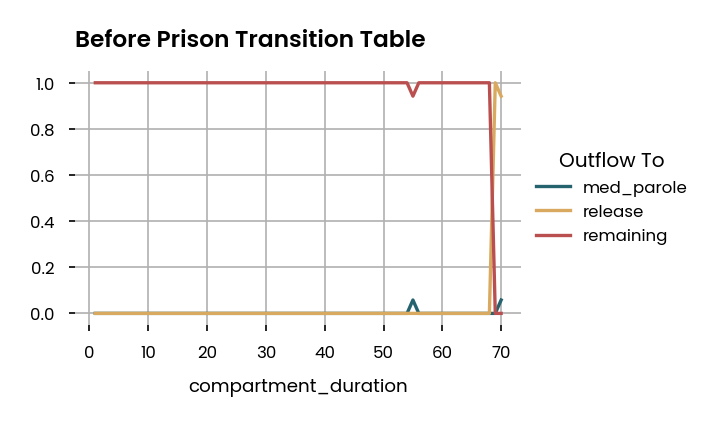

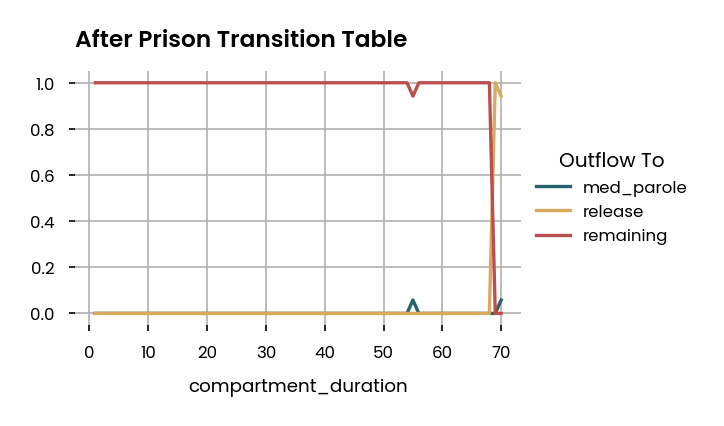

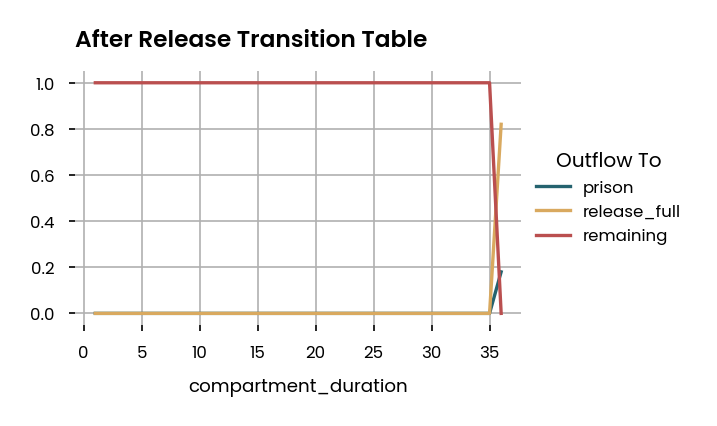

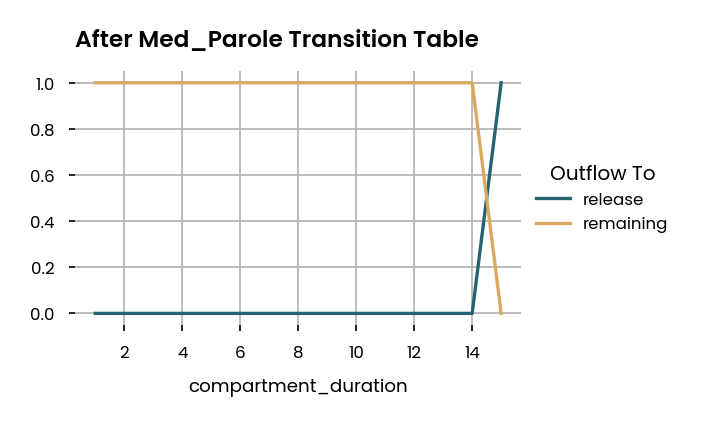

In [128]:
from recidiviz.calculator.modeling.population_projection.transition_table import TransitionTableType
for compartment in ["prison", "release", "med_parole"]:
    transition_dfs = test_sim.validator.pop_simulations["policy"].sub_simulations["x"]\
            .simulation_compartments[compartment].compartment_transitions.transition_tables
    policy_key = max(transition_dfs.keys())
    for transition_type in [TransitionTableType.BEFORE, TransitionTableType.AFTER]:
        if (policy_key != 15) & (transition_type == TransitionTableType.BEFORE):
            continue
        transition_dfs[policy_key].transition_dfs[transition_type].plot()
        plt.title(f"{transition_type.name.title()} {compartment.title()} Transition Table")
        add_legend(title="Outflow To")

In [57]:
test_sim.validator.pop_simulations.keys()

dict_keys(['policy', 'control'])

[<AxesSubplot:title={'left':'compartment: pretrial\noutflow_to: prison'}, xlabel='time_step'>]

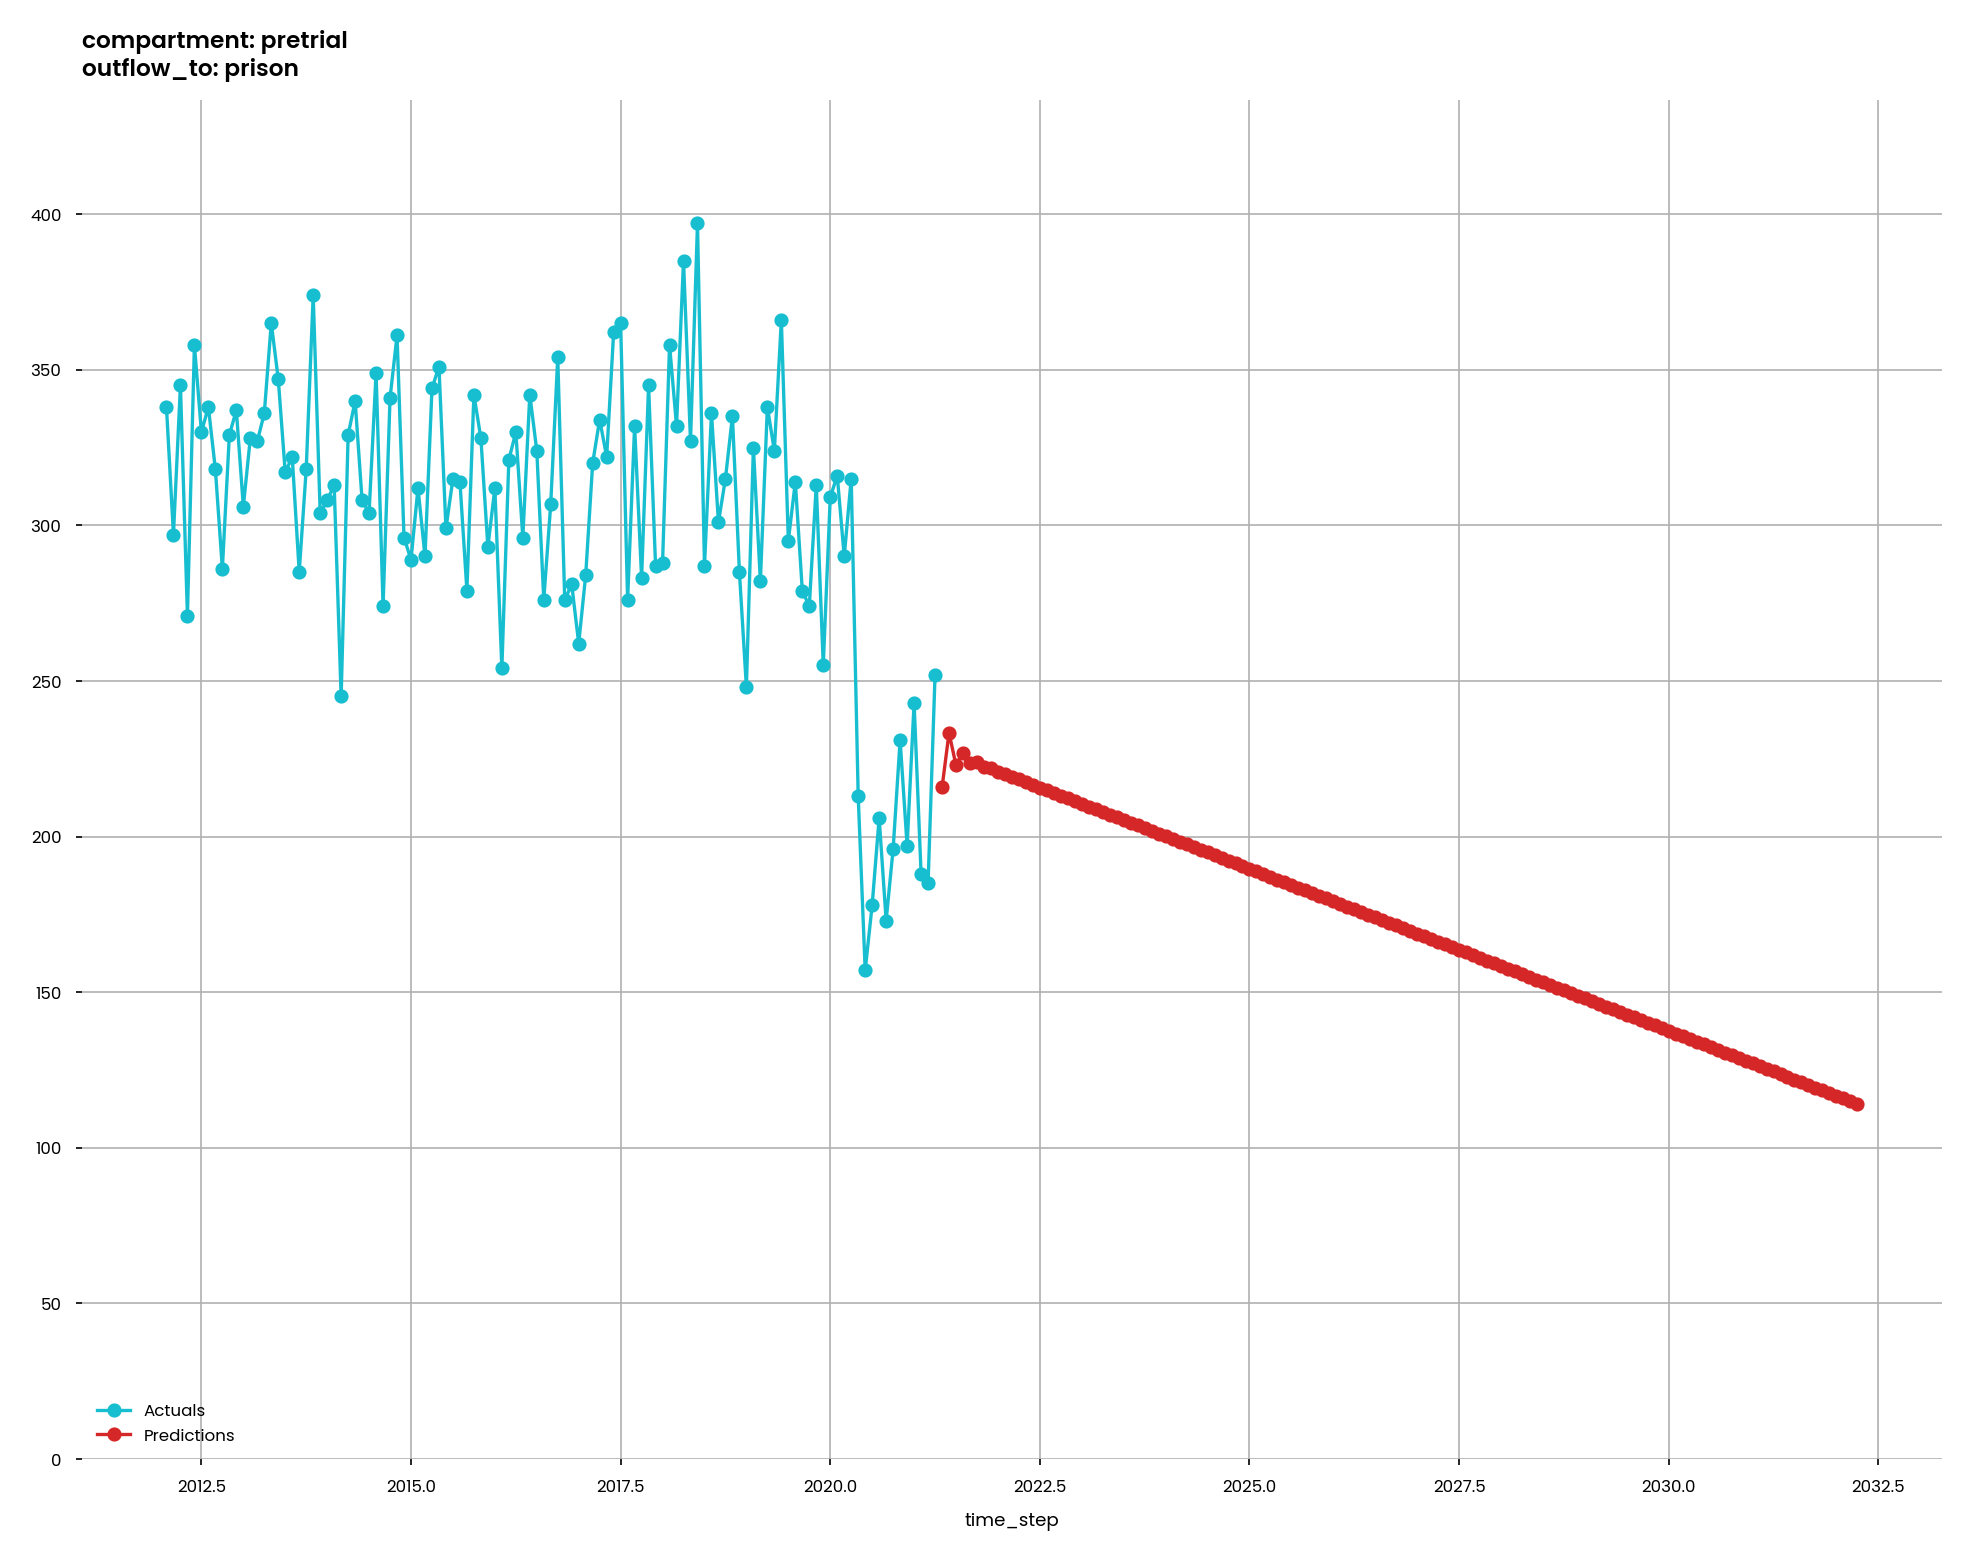

In [22]:
test_sim.get_arima_output_plots(simulation_title="control")

<AxesSubplot:xlabel='time_step'>

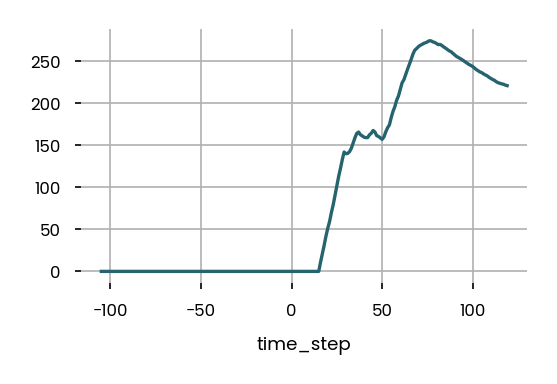

In [87]:
med_parole = test_sim.validator.pop_simulations["policy"].population_projections.set_index(
    ["compartment", "time_step"]).loc["med_parole"]
med_parole["total_population"].plot()

In [88]:
med_parole.loc[26]

total_population    112.909247
simulation_group             x
Name: 26, dtype: object

Text(0.0, 1.0, 'OR SB 835 Population Projection')

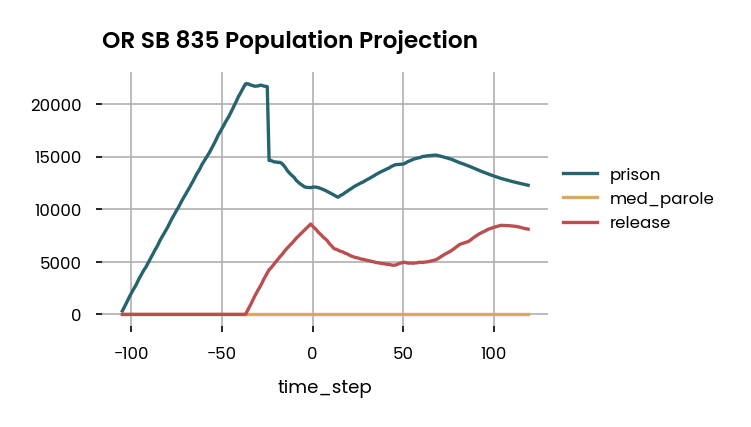

In [91]:
baseline_output = test_sim.validator.pop_simulations["control"].population_projections
baseline_output.set_index(["compartment", "time_step"]).loc[["prison", "med_parole", "release"], :].unstack("compartment")["total_population"].plot()
add_legend()
plt.title("OR SB 835 Population Projection")

Text(0.0, 1.0, 'OR SB 835 Population Projection')

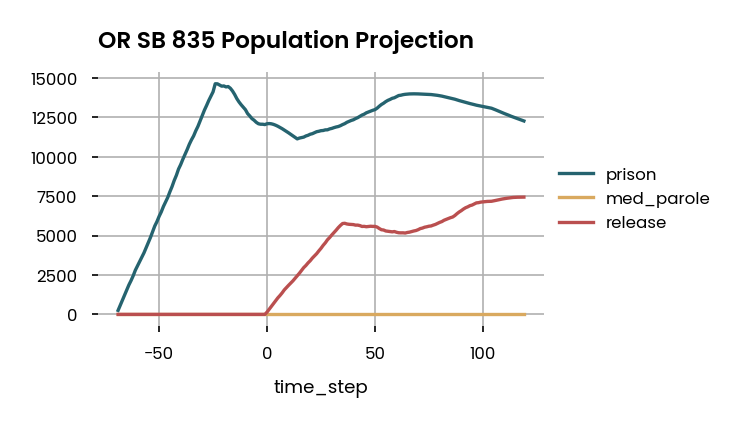

In [197]:
baseline_output = test_sim.validator.pop_simulations["control"].population_projections
baseline_output.set_index(["compartment", "time_step"]).loc[["prison", "med_parole", "release"], :].unstack("compartment")["total_population"].plot()
add_legend()
plt.title("OR SB 835 Population Projection")

Text(0.0, 1.0, 'OR SB 835 Population Projection')

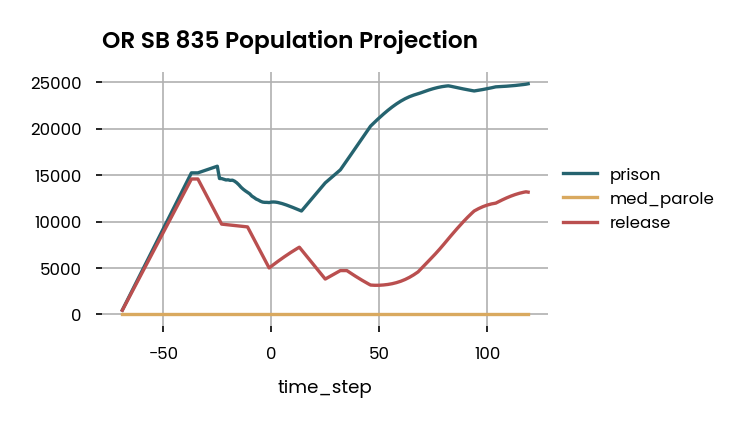

In [167]:
baseline_output = test_sim.validator.pop_simulations["control"].population_projections
baseline_output.set_index(["compartment", "time_step"]).loc[["prison", "med_parole", "release"], :].unstack("compartment")["total_population"].plot()
add_legend()
plt.title("OR SB 835 Population Projection")

Text(0.0, 1.0, 'Baseline Simulation Projected Transitions')

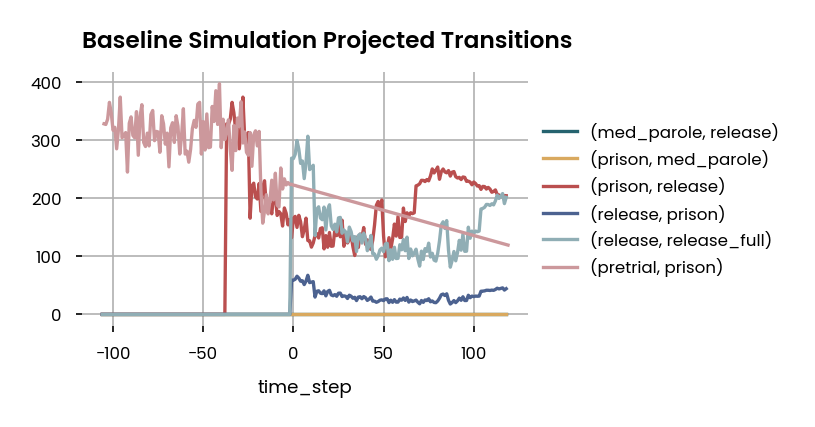

In [48]:
baseline_outflows = test_sim.validator.pop_simulations["control"].get_outflows().copy()
baseline_outflows = baseline_outflows[baseline_outflows["compartment"] != "release_full"]
baseline_outflows.groupby(["time_step", "compartment", "outflow_to"]).sum()["total_population"]\
    .unstack(["compartment", "outflow_to"]).plot()
add_legend()
plt.title("Baseline Simulation Projected Transitions")

Text(0.0, 1.0, 'Baseline Simulation Projected Transitions')

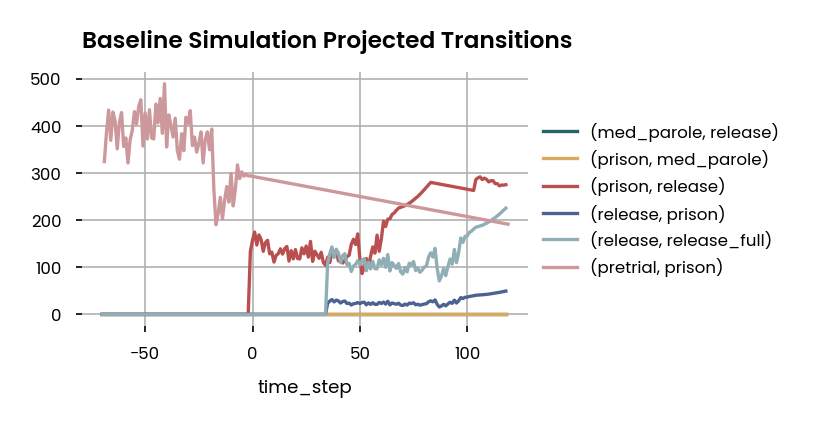

In [188]:
baseline_outflows = test_sim.validator.pop_simulations["control"].get_outflows().copy()
baseline_outflows = baseline_outflows[baseline_outflows["compartment"] != "release_full"]
baseline_outflows.groupby(["time_step", "compartment", "outflow_to"]).sum()["count"]\
    .unstack(["compartment", "outflow_to"]).plot()
add_legend()
plt.title("Baseline Simulation Projected Transitions")

Text(0.0, 1.0, 'Policy Simulation Projected Transitions')

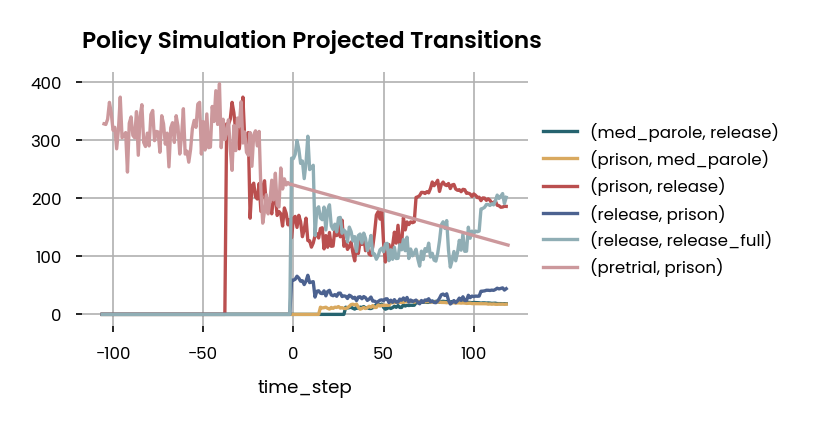

In [64]:
policy_outflows = test_sim.validator.pop_simulations["policy"].get_outflows().copy()
policy_outflows = policy_outflows[policy_outflows["compartment"] != "release_full"]
policy_outflows.groupby(["time_step", "compartment", "outflow_to"]).sum()["total_population"]\
    .unstack(["compartment", "outflow_to"]).plot()
add_legend()
plt.title("Policy Simulation Projected Transitions")

Text(0.0, 1.0, 'Policy Simulation Projected Transitions')

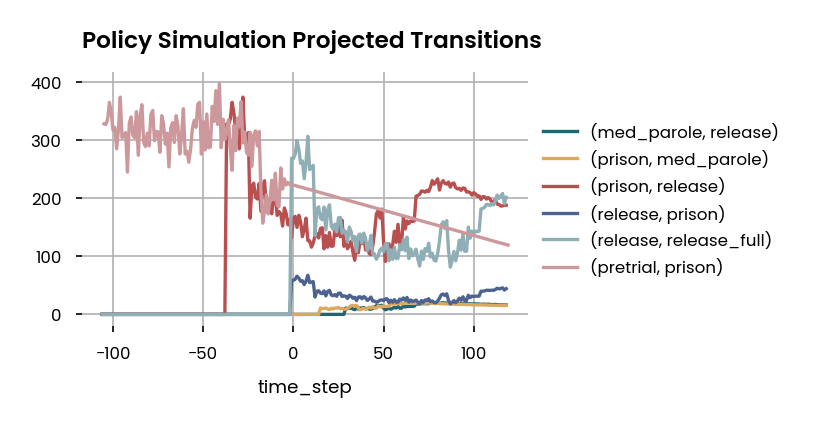

In [89]:
policy_outflows = test_sim.validator.pop_simulations["policy"].get_outflows().copy()
policy_outflows = policy_outflows[policy_outflows["compartment"] != "release_full"]
policy_outflows.groupby(["time_step", "compartment", "outflow_to"]).sum()["total_population"]\
    .unstack(["compartment", "outflow_to"]).plot()
add_legend()
plt.title("Policy Simulation Projected Transitions")

In [168]:
%%bigquery outflows_df
WITH latest_runs AS
(
SELECT simulation_tag, MAX(date_created) as latest_run
FROM `recidiviz-staging.spark_public_input_data.outflows_data_raw`
GROUP BY simulation_tag
)
SELECT data.*
FROM `recidiviz-staging.spark_public_input_data.outflows_data_raw` data
LEFT JOIN latest_runs ON data.simulation_tag = latest_runs.simulation_tag
WHERE data.simulation_tag = 'OR_835'
    AND date_created = latest_runs.latest_run

Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 111/111 [00:01<00:00, 75.76rows/s]


In [169]:
outflows_df.head()

,simulation_tag,time_step,compartment,outflow_to,total_population,crime,crime_type,age,race,date_created
0,OR_835,-15,pretrial,prison,248.0,None,None,x,None,2021-10-19 19:40:25.057625+00:00
1,OR_835,-71,pretrial,prison,368.0,None,None,x,None,2021-10-19 19:40:25.057625+00:00
2,OR_835,-42,pretrial,prison,384.0,None,None,x,None,2021-10-19 19:40:25.057625+00:00
3,OR_835,-117,pretrial,prison,400.0,None,None,x,None,2021-10-19 19:40:25.057625+00:00
4,OR_835,-108,pretrial,prison,400.0,None,None,x,None,2021-10-19 19:40:25.057625+00:00


In [170]:
outflows_df["age"].value_counts(dropna=False)

x    111
Name: age, dtype: int64

Text(0.0, 1.0, 'OR SB 835 Outflows')

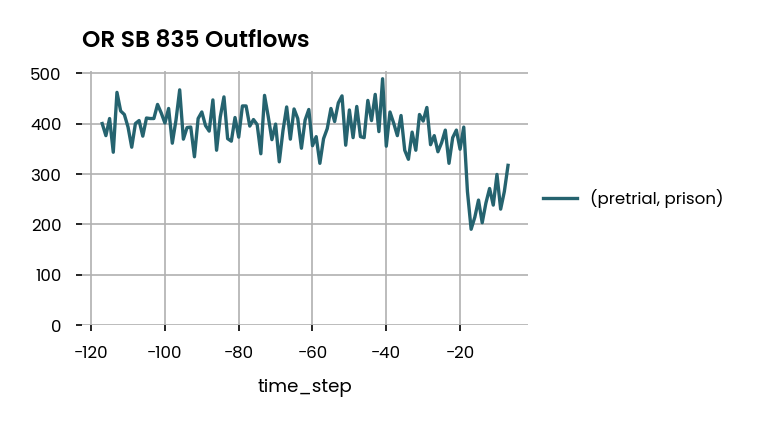

In [171]:
outflows_df.set_index(["time_step", "compartment", "outflow_to"]).unstack(["compartment", "outflow_to"])\
    ["total_population"].plot()
add_legend()
plt.ylim([0, None])
plt.title("OR SB 835 Outflows")

Text(0.0, 1.0, 'OR SB 835 Outflows')

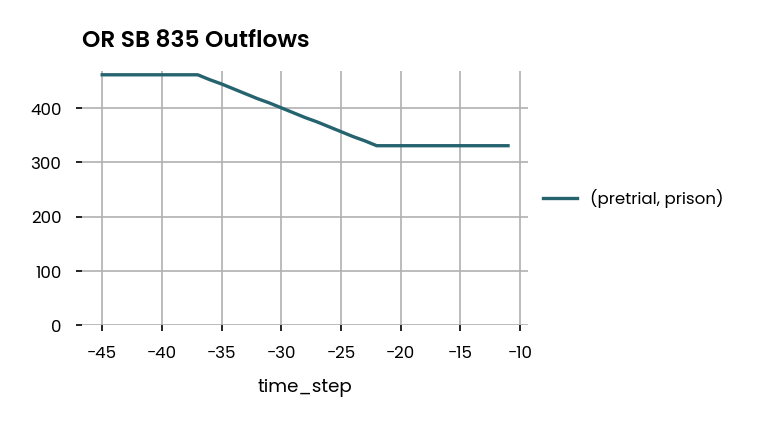

In [66]:
outflows_df.set_index(["time_step", "compartment", "outflow_to"]).unstack(["compartment", "outflow_to"])\
    ["total_population"].plot()
add_legend()
plt.ylim([0, None])
plt.title("OR SB 835 Outflows")

In [61]:
slope = (331 - 462)/15
slope

-8.733333333333333

In [97]:
%%bigquery population_df
WITH latest_runs AS
(
SELECT simulation_tag, MAX(date_created) as latest_run
FROM `recidiviz-staging.spark_public_input_data.total_population_data_raw`
GROUP BY simulation_tag
)
SELECT data.*
FROM `recidiviz-staging.spark_public_input_data.total_population_data_raw` data
LEFT JOIN latest_runs ON data.simulation_tag = latest_runs.simulation_tag
WHERE data.simulation_tag = 'OR_835'
    AND date_created = latest_runs.latest_run
ORDER BY time_step

Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 29.18rows/s]


In [98]:
population_df.head()

,simulation_tag,time_step,compartment,total_population,crime,crime_type,age,race,date_created
0,OR_835,-24,prison,14635.0,None,None,x,None,2021-10-20 12:56:39.349718+00:00
1,OR_835,-23,prison,14632.0,None,None,x,None,2021-10-20 12:56:39.349718+00:00
2,OR_835,-22,prison,14555.0,None,None,x,None,2021-10-20 12:56:39.349718+00:00
3,OR_835,-21,prison,14483.0,None,None,x,None,2021-10-20 12:56:39.349718+00:00
4,OR_835,-20,prison,14497.0,None,None,x,None,2021-10-20 12:56:39.349718+00:00


Text(0.0, 1.0, 'OR SB 835 Total Population')

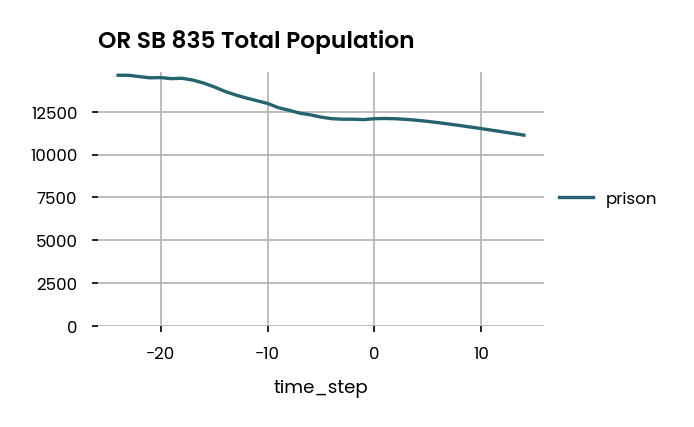

In [99]:
population_df.set_index(["time_step", "compartment"]).unstack(["compartment"])["total_population"].plot()
add_legend()
plt.ylim([0, None])
plt.title("OR SB 835 Total Population")

0     14635.0
1     14632.0
2     14555.0
3     14483.0
4     14497.0
5     14435.0
6     14458.0
7     14351.0
8     14178.0
9     13956.0
10    13694.0
11    13484.0
12    13306.0
13    13149.0
14    12989.0
15    12742.0
16    12593.0
17    12424.0
18    12322.0
19    12190.0
20    12098.0
21    12068.0
22    12067.0
23    12045.0
24    12097.0
Name: total_population, dtype: float64

Text(0.0, 1.0, 'OR SB 835 Total Population')

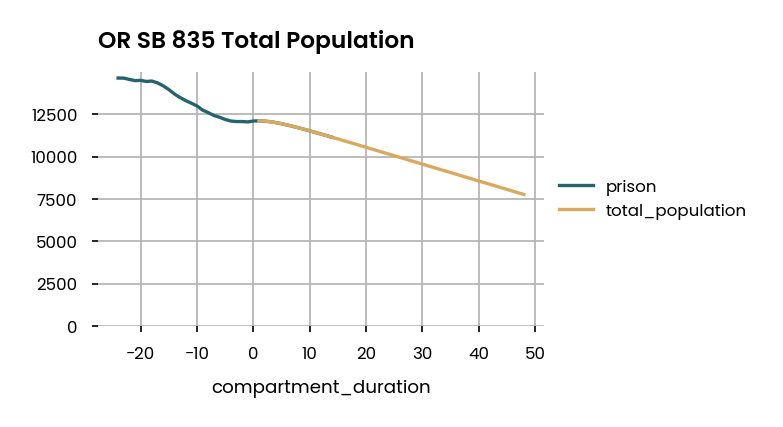

In [105]:
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
historical_values = (
    population_df[population_df["time_step"] <= 0].sort_values(by="time_step")["total_population"].values
)
projected_values = ARIMA(historical_values, order=(1, 1, 0), trend="t")\
    .fit()\
    .forecast(steps=48)
ax = population_df.set_index(["time_step", "compartment"]).unstack(["compartment"])["total_population"].plot()
pd.DataFrame({"total_population": projected_values, "compartment_duration": range(1, 49)}).plot(
    x="compartment_duration", ax=ax)
add_legend()
plt.ylim([0, None])
plt.title("OR SB 835 Total Population")


In [106]:
projected_values

array([12110.15561963, 12094.42726859, 12057.22132533, 12004.04503737,
       11938.99349323, 11865.11172584, 11784.66396596, 11699.33385418,
       11610.37331484, 11518.71325596, 11425.04588375, 11329.88591007,
       11233.61606522, 11136.52094049, 11038.81215273, 10940.64705637,
       10842.14265727, 10743.38595888, 10644.44165533, 10545.35785203,
       10446.17031927, 10346.90565517, 10247.58363763, 10148.2189731 ,
       10048.82259707,  9949.40264094,  9849.96515108,  9750.51462345,
        9651.05440119,  9551.58697017,  9452.11417885,  9352.6374017 ,
        9253.15766078,  9153.67571604,  9054.19213258,  8954.7073306 ,
        8855.22162255,  8755.73524077,  8656.248358  ,  8556.76110272,
        8457.27357045,  8357.7858322 ,  8258.29794079,  8158.80993551,
        8059.32184554,  7959.8336926 ,  7860.34549284,  7760.85725826])